In [1]:
import os
import random
import re
import time

import pandas as pd
import numpy as np
# import warnings
import warnings
import seaborn as sns
import os
import matplotlib.pyplot as plt

from scipy import stats

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier, Perceptron, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier 

import skopt
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

# ignore warnings
warnings.filterwarnings("ignore")
# Any results you write to the current directory are saved as output.

# Primeiros Passos

- Este Dataset representa dados de uma empresa de seguro de vida interessada em expandir para seus clientes seguro de veículos.
- O objetivo então é criar um modelo que consiga prever se uma pessoa que já é cliente de seguro de vida se interessaria em fazer um seguro de veículo.

### Carregando o arquivo e primeiras análises

In [2]:
dtrain = pd.read_csv('./input/train.csv')
dtest = pd.read_csv('./input/test.csv')

In [3]:
dtrain.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


## Visualizando

- Vamos começar visualizando a relação entre gênero e a resposta

In [69]:
df=dtrain.groupby(['Gender','Response'])['id'].count().to_frame().rename(columns={'id':'count'}).reset_index()

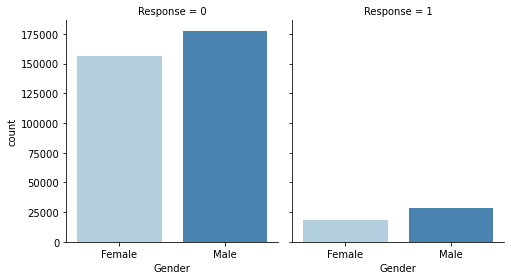

In [70]:
g = sns.catplot(x="Gender", y="count",col="Response",
                data=df, kind="bar",
                height=4, aspect=.9, palette='Blues');

In [71]:
df2=dtrain.groupby(['Vehicle_Age','Response'])['id'].count().to_frame().rename(columns={'id':'count'}).reset_index()

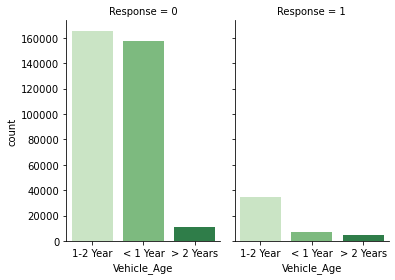

In [72]:
g = sns.catplot(x="Vehicle_Age", y="count",col="Response",
                data=df2, kind="bar",
                height=4, aspect=.7, palette='Greens');

In [79]:
dtrain['Income'] = dtrain['Annual_Premium'].apply(lambda x: '> 30000' if  x>30000 else '< 30000')
df2=dtrain.groupby(['Income','Response'])['id'].count().to_frame().rename(columns={'id':'count'}).reset_index()

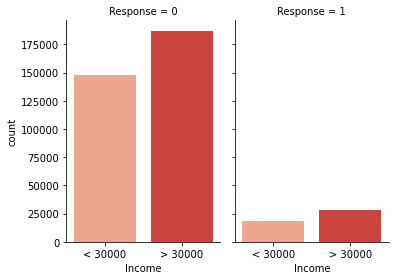

In [81]:
g = sns.catplot(x="Income", y="count",col="Response",
                data=df2, kind="bar",
                height=4, aspect=.7, palette='Reds');
dtrain = dtrain.drop('Income', axis=1)

In [83]:
dtrain['Age_cat'] = dtrain['Age'].apply(lambda x: '< 30' if  x< 30 else ( '> 30 and < 60') if x < 60 else '> 60')
df2=dtrain.groupby(['Age_cat','Response'])['id'].count().to_frame().rename(columns={'id':'count'}).reset_index()

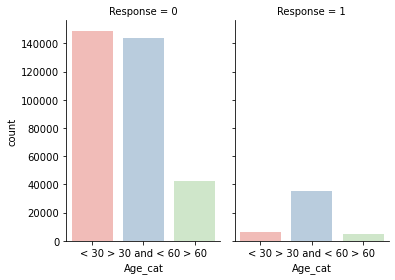

In [85]:
g = sns.catplot(x="Age_cat", y="count",col="Response",
                data=df2, kind="bar",
                height=4, aspect=.7, palette='Pastel1');
dtrain = dtrain.drop('Age_cat', axis=1)

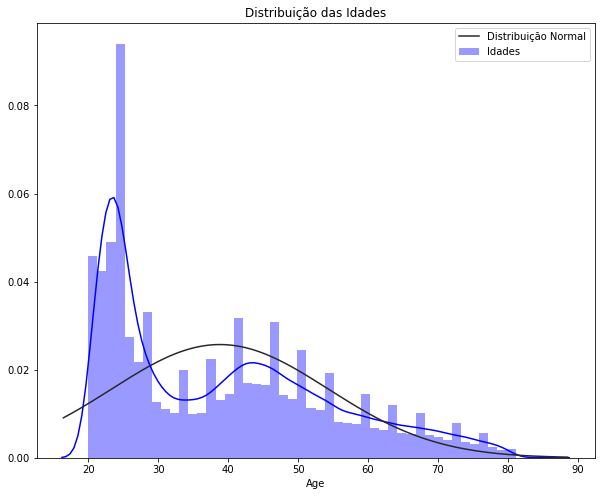

In [82]:
plt.figure(figsize=(10,8))
plt.title('Distribuição das Idades')
sns.distplot(dtrain['Age'], kde=True, color='blue', fit=stats.norm)
plt.legend(['Distribuição Normal', 'Idades'])


- Constatamos um gráfico descendente: O número de pessoas com seguro de vida decai em idades mais avançadas

In [ ]:
plt.figure(figsize=(10,8))
plt.title('Distribuição das Idades')
sns.distplot(dtrain['Age'], kde=True, color='green', fit=stats.norm)
plt.legend(['Distribuição Normal', 'Idades'])

### Correlação

- Vamos ferificar a correlação entre o interesse em fazer um seguro para o veículo com as demais variáveis

<AxesSubplot:>

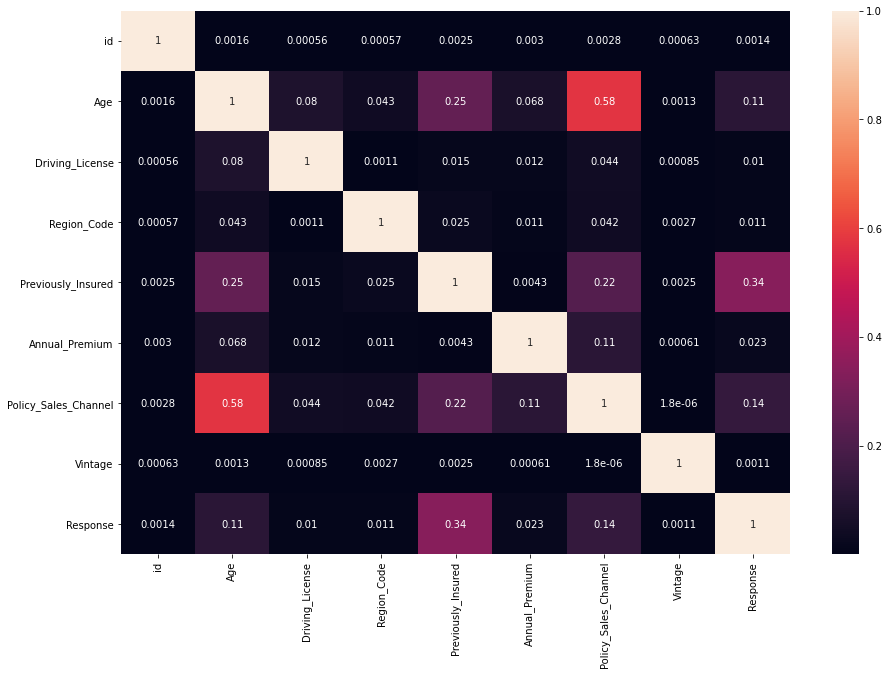

In [9]:
plt.figure(figsize=(15,10))
sns.heatmap(dtrain.corr().abs(), annot=True)

- Constatamos que 'Previously_insured'(Já fez seguro antes), Idade e a politica de vendas foram as variáveis com maior correlação

### Transformações no Dataset

- Irei Retirar algumas das variáveis com as correlações mais baixas:

In [10]:
columns_drop = ['Vintage', 'id', 'Region_Code', 'Vintage']
dtrain.drop(columns_drop, axis=1)
dtest.drop(columns_drop, axis=1)

,Gender,Age,Driving_License,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel
0,Male,25,1,1,< 1 Year,No,35786.0,152.0
1,Male,40,1,0,1-2 Year,Yes,33762.0,7.0
2,Male,47,1,0,1-2 Year,Yes,40050.0,124.0
3,Male,24,1,1,< 1 Year,Yes,37356.0,152.0
4,Male,27,1,1,< 1 Year,No,59097.0,152.0
...,...,...,...,...,...,...,...,...
127032,Female,26,1,1,< 1 Year,No,30867.0,152.0
127033,Female,38,1,0,1-2 Year,Yes,28700.0,122.0
127034,Male,21,1,1,< 1 Year,No,29802.0,152.0
127035,Male,71,1,1,1-2 Year,No,62875.0,26.0


- Agora, transformarei as variáveis catégoricas em numéricas, para poder utiliza-las no Modelo 

In [11]:
from sklearn.preprocessing import LabelEncoder
cat_features = ['Gender', 'Vehicle_Age', 'Vehicle_Damage']
encoder = LabelEncoder()

encodedtrain = dtrain[cat_features].apply(encoder.fit_transform)
encodedtest = dtest[cat_features].apply(encoder.fit_transform)

In [12]:
other_columns = ['Age', 'Driving_License', 'Previously_Insured', 'Annual_Premium', 'Policy_Sales_Channel', 'Response']
other_columns1 = ['Age', 'Driving_License', 'Previously_Insured', 'Annual_Premium', 'Policy_Sales_Channel']
dtrain = dtrain[other_columns].join(encodedtrain)
dtest = dtest[other_columns1].join(encodedtrain)

In [13]:
dtrain.head()

,Age,Driving_License,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Response,Gender,Vehicle_Age,Vehicle_Damage
0,44,1,0,40454.0,26.0,1,1,2,1
1,76,1,0,33536.0,26.0,0,1,0,0
2,47,1,0,38294.0,26.0,1,1,2,1
3,21,1,1,28619.0,152.0,0,1,1,0
4,29,1,1,27496.0,152.0,0,0,1,0


# Modelagem

- Iremos construir nosso modelo utilizando com base modelos para resolução de problemas de classificação
- Começaremos dividindo o Dataset em dois: Train e Test
- Depois, verificaremos o desempenho de alguns destes modelos com os parâmetros padrão

In [22]:
N = len(dtrain)
TRAIN_PERC = 0.8
ind_train = np.random.rand(N)  < TRAIN_PERC
train, test = dtrain[ind_train], dtrain[~ind_train]
print(f'len(train)={len(train)}; len(test)={len(test)}')

len(train)=304894; len(test)=76215


In [23]:
X_train = train.drop('Response', axis=1)
y_train = train['Response']
X_test = test.drop('Response', axis=1)
y_test = test['Response']

In [24]:
clf_dict = {
    'KNeighborsClassifier' : KNeighborsClassifier,
    'LogisticRegression': LogisticRegression,
    'MultinomialNB': MultinomialNB,
    'DecisionTreeClassifier': DecisionTreeClassifier,
    'SGDClassifier': SGDClassifier,
    'Perceptron': Perceptron,
    'RidgeClassifier': RidgeClassifier,
    'LinearSVC': LinearSVC,
    'RandomForestClassifier': RandomForestClassifier,
    'GradientBoostingClassifier': GradientBoostingClassifier
}

In [25]:
def get_accuracy(clf, n_estimators=None, max_depth=None, learning_rate=None, max_iter=None):
    start = time.time()
    if clf == KNeighborsClassifier:
        text_clf = clf(params).fit(X_train, y_train)
    else:    
        text_clf = clf(**params).fit(X_train, y_train)
    predicted = text_clf.predict(X_test)
    print(f'Accuracy gets in {round(time.time()-start, 2)}s.')
    return np.mean(predicted == y_test)

result_dict = {}

for clf_str, clf_fn in clf_dict.items():
    if clf_str == 'LogisticRegression':
        params = {'max_iter': 200}
    elif clf_str == 'RandomForestClassifier':
        params = {'n_estimators': 50,
                'max_depth':10}
    elif clf_str == 'DecisionTreeClassifier':
        params = {'max_depth' : 10}
    elif clf_str == 'GradientBoostingClassifier':
        params = {'n_estimators': 50,
                  'learning_rate': 0.1}
    elif clf_str == 'KNeighborsClassifier':
        params = 10
    else:
        params = {}
    if clf_fn == KNeighborsClassifier:
        accuracy = get_accuracy(clf_fn, params)
    else:
        accuracy = get_accuracy(clf=clf_fn, **params)
    result_dict[clf_str] = accuracy
    print(f'Clf={clf_str}; Accuracy={accuracy}')

Accuracy gets in 16.09s.
Clf=KNeighborsClassifier; Accuracy=0.8749458767959063
Accuracy gets in 3.14s.
Clf=LogisticRegression; Accuracy=0.8759299350521551
Accuracy gets in 0.12s.
Clf=MultinomialNB; Accuracy=0.6815325067243981
Accuracy gets in 0.94s.
Clf=DecisionTreeClassifier; Accuracy=0.8773207373876534
Accuracy gets in 25.78s.
Clf=SGDClassifier; Accuracy=0.8780555008856524
Accuracy gets in 0.59s.
Clf=Perceptron; Accuracy=0.8378140785934527
Accuracy gets in 0.22s.
Clf=RidgeClassifier; Accuracy=0.8780817424391524
Accuracy gets in 79.89s.
Clf=LinearSVC; Accuracy=0.8780817424391524
Accuracy gets in 15.57s.
Clf=RandomForestClassifier; Accuracy=0.8780686216624024
Accuracy gets in 20.37s.
Clf=GradientBoostingClassifier; Accuracy=0.8780817424391524


In [26]:
result_dict = {
    k: v
    for k, v in sorted(
        result_dict.items(),
        key=lambda x: x[1],
        reverse=True
    )
}

result_dict

{'RidgeClassifier': 0.8780817424391524,
 'LinearSVC': 0.8780817424391524,
 'GradientBoostingClassifier': 0.8780817424391524,
 'RandomForestClassifier': 0.8780686216624024,
 'SGDClassifier': 0.8780555008856524,
 'DecisionTreeClassifier': 0.8773207373876534,
 'LogisticRegression': 0.8759299350521551,
 'KNeighborsClassifier': 0.8749458767959063,
 'Perceptron': 0.8378140785934527,
 'MultinomialNB': 0.6815325067243981}

- Alcançamos uma precisão de 87.8% com os parâmetros padrão!
- Vamos verificar se consenguimoms optmizar essa precisão com alterações nos parâmetros

In [27]:
DIM_Logistic = [
    Integer(100, 400, name='max_iter')
]

DIM_SVC = [
    Real(1e-5, 1, name='tol', prior='log-uniform'),
    Real(0.1, 1.5, name='C', prior='log-uniform')
]

DIM_SGDC = [
    Real(1e-5, 1e-2, name='alpha', prior='log-uniform')
]

DIM_RF = [
    Integer(1, 100, name='n_estimators'),
    Integer(5, 30, name='max_depth')
]

DIM_TREE = [
    Integer(5, 30, name='max_depth'),
]

DIMS = {
    'LogisticRegression': DIM_Logistic,
    'LinearSVC': DIM_SVC,
    'SGDClassifier': DIM_SGDC,
    'RandomForestClassifier': DIM_RF,
    'DecisionTreeClassifier': DIM_TREE
}

In [28]:
def optimize(clf_str='LinearSVC'):
    
    dimensions = DIMS[clf_str]
    print(dimensions)
    
    @use_named_args(dimensions=dimensions)
    def fitness(**params):
        clf = clf_dict[clf_str](**params)
        text_clf = clf.fit(X_train, y_train)
        predicted = text_clf.predict(X_test)
        accuracy = np.mean(predicted == y_test)
        print(f'accuracy = {accuracy} with params = {params}')
        return -1.0 *accuracy
    
    res = gp_minimize(func=fitness,
                     dimensions=dimensions,
                     acq_func='EI',
                     n_calls=10,
                     random_state=666)
    print(f'best accuracy={-1.0 * res.fun} with {res.x}')
    return res

In [29]:
res_dict = {}
for clf_str, clf_dim in DIMS.items():
    print(f'start optimizaton for {clf_str}')
    res = optimize(clf_str=clf_str)
    res_dict[clf_str] = res

start optimizaton for LogisticRegression
[Integer(low=100, high=400, prior='uniform', transform='identity')]
accuracy = 0.8759299350521551 with params = {'max_iter': 131}
accuracy = 0.8759299350521551 with params = {'max_iter': 163}
accuracy = 0.8759299350521551 with params = {'max_iter': 139}
accuracy = 0.8759299350521551 with params = {'max_iter': 325}
accuracy = 0.8759299350521551 with params = {'max_iter': 201}
accuracy = 0.8759299350521551 with params = {'max_iter': 173}
accuracy = 0.8759299350521551 with params = {'max_iter': 178}
accuracy = 0.8759299350521551 with params = {'max_iter': 184}
accuracy = 0.8759299350521551 with params = {'max_iter': 239}
accuracy = 0.8759299350521551 with params = {'max_iter': 170}
best accuracy=0.8759299350521551 with [131]
start optimizaton for LinearSVC
[Real(low=1e-05, high=1, prior='log-uniform', transform='identity'), Real(low=0.1, high=1.5, prior='log-uniform', transform='identity')]
accuracy = 0.8778324476809027 with params = {'tol': 3.2590

In [30]:
for clf_str, res in res_dict.items():
    hyperparameters_label = [hp.name for hp in DIMS[clf_str]]
    best_hyperparameters = dict(zip(hyperparameters_label, res.x))
    print(f'clf={clf_str}\nbest accuracy={-res.fun}\nbest hyperparameters={best_hyperparameters}\n')

clf=LogisticRegression
best accuracy=0.8759299350521551
best hyperparameters={'max_iter': 131}

clf=LinearSVC
best accuracy=0.8780817424391524
best hyperparameters={'tol': 4.414527342912078e-05, 'C': 0.7628816961239331}

clf=SGDClassifier
best accuracy=0.8768746309781539
best hyperparameters={'alpha': 4.3052494479948036e-05}

clf=RandomForestClassifier
best accuracy=0.8781473463229024
best hyperparameters={'n_estimators': 27, 'max_depth': 12}

clf=DecisionTreeClassifier
best accuracy=0.8778718100111527
best hyperparameters={'max_depth': 8}



# Conclusão

- Apesar de homens estarem em maior quantidade entre as pessoas com seguro de vida e entre aqueles que já tiveram seus veículos danificados, esse número não se traduz em interesse em fazer seguro de veículo
- A maior relação está entre àqueles que já tiveram danos em seus veículos
- A maioria dos interessados tem idade entre 30 e 60 anos
- A precisão do modelo é de 87.81%